## <font color=#0099CC>mIAx - Taller Renta Fija - ANÁLISIS CARTERA DE RENTA FIJA</font>

En esta práctica, desarrollaremos un análisis relativamente exahustivo de un universo de Renta Fija, en concreto, de bonos corporativos. Además, construiremos y analizaremos varias carteras. 

Para ello, contaremos con la siguiente información almacenada en la carpeta *data*:
- Universo de bonos, con sus características esenciales (fichero *universo.csv*)
- Histórico de precios de cierre del universo de bonos anterior (fichero *precios_historicos_universo.csv*)
- Curva de tipos de interés €STR (fichero *curvaESTR.csv*)
- Histórico de precios de otros índices que nos serán de utilidad (fichero *precios_historicos_varios*):
    - Índices de crédito: ITRAXX Main y ITRAXX XOVER. Serán útiles para la cobertura del riesgo de crédito.
    - Futuros sobre el *Schatz* (DU1), *BOBL* (OE1) y *BUND* (RX1). Serán útiles para la cobertura de los tipos de interés.
    - Índice de crédito *RECMTREU*, que valdría como benchmark de las carteras que construyamos.

No necesariamente se usará toda toda la información

En líneas generales, estos son los ejercicios que completaremos, aunque los detallaremos más en cada apartado:
1. Análisis de datos. En esta sección, haremos un análisis de la información que tenemos de cada bono y lo que significa. Asimismo, haremos los tratamientos y limpieza que necesitemos para luego poder usarlos.
2. Valoración de los bonos del universo utilizando la curva de descuento y bajo ciertas asunciones. Comparación de estos precios con los precios de mercado.
3. Cálculo del spread que pagan los bonos sobre la curva.
4. Cálculo de *yield*, duración y convexidad.
5. Contrucción de una cartera equiponderada con todos los bonos del universo. Contraste con el benchmark (os proponemos el índice RECMTREU para el que os hemos dado los precios) y backtest de la estrategia. ¡OJO! El índice es *Total Return*.
6. Tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
    - La duración de la cartera no debe superar los 3 años
    - La exposición a emisiones HY no puede superar el 10% de la cartera
    - No puedes invertir en deuda subordinada
    - No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
    - No se puede invertir más de un 10% del capital en una misma emisión
    - No puede haber más de un 15% de concentración en un mismo emisor
    (¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

    6.1. Constrúyela a fecha de hoy

    6.2. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

    6.3. ¿Cómo medirías el riesgo de crédito de la cartera?

    6.4. ¿Cómo medirías el riesgo de liquidez de la cartera?

    6.5. Describe cómo habría que hacer el backtest de esta cartera
7. Ahora, se te pide que cubras la exposición de la cartera a los tipos de interés. Con la información que tienes, ¿cómo lo harías?
8. ¿Y si quisieras cubrir total o parcialmente el riesgo de crédito? Usa de nuevo la información que tienes.
9. ¿Cómo construirías tu cartera? ¿Se te ocurre alguna estrategia específica, por ejemplo, de valor relativo?


📣 <font color=#CC6600>**¡NORMAS!**</font>

La práctica se puede hacer en grupos de hasta **3 personas** y deberá entregarse antes del **27 de noviembre**. 

Cada grupo expondrá una parte de los ejercicios en la clase del día 27, donde la resolveremos juntos a modo de taller. Esta exposición contará hasta **1 punto** de la nota final.

Además, se valorará positivamente para la práctica la participación en las clases.

📣 <font color=#CC6600>**¡IMPORTANTE!**</font>

Todo el código implementado debe estar debidamente comentado e incluir conclusiones de los resultados obtenidos para optar a la máxima puntuación. Asimismo, se debe responder a las preguntas planteadas.

Las propuestas de mejora o posibles trabajos futuros se valorarán positivamente también.

Usa las fuentes de información que consideres necesarias para apoyar tus respuestas.

### <font color=#336699>Librerías</font>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import os

# Configuración de paths y fecha
current_dir = os.getcwd()
data_path = os.path.join(os.path.dirname(current_dir), 'data') if 'src' in current_dir else '../data' if os.path.exists('../data') else 'data'
fecha_analisis = datetime(2025, 10, 1)

### <font color=#336699>1. Datos</font>

<style>.gray {background-color: #595959}

</style><div class="gray">❕💬¿Qué observas en los datos? Analiza la información que tenemos del universo</div>

In [33]:
universo = pd.read_csv(os.path.join(data_path, 'universo.csv'), sep=';')
universo['Maturity'] = pd.to_datetime(universo['Maturity'], format='%d/%m/%Y', errors='coerce')
vivos = universo[universo['Maturity'] > fecha_analisis].copy()

# Cargar y preparar curva €STR
curva = pd.read_csv(os.path.join(data_path, 'curvaESTR.csv'), sep=';')
curva_work = curva.copy()
curva_work['Date'] = pd.to_datetime(curva_work['Date'], format='%d/%m/%Y', errors='coerce')
curva_work = curva_work.dropna(subset=['Date'])
curva_work['Tenor'] = (curva_work['Date'] - fecha_analisis).dt.days / 365.25

if 'Zero Rate' in curva_work.columns:
    if curva_work['Zero Rate'].max() > 1:
        curva_work['Zero Rate'] /= 100

if 'Discount' not in curva_work.columns or curva_work['Discount'].isna().any():
    curva_work['Discount'] = np.exp(-curva_work['Zero Rate'] * curva_work['Tenor'])

curva_work = curva_work[['Tenor', 'Zero Rate', 'Discount']].sort_values('Tenor')

print(f"Bonos vivos: {len(vivos)}")
print(f"Puntos en curva: {len(curva_work)}")

Bonos vivos: 2236
Puntos en curva: 33


#### <font color=#808080>Divisas</font>

In [16]:
# Análisis de Divisas
divisas = vivos['Ccy'].unique()
divisas_count = vivos['Ccy'].value_counts()

print("="*60)
print("ANÁLISIS DE DIVISAS")
print("="*60)
print(f"\nDivisas presentes en el universo: {', '.join(divisas.astype(str))}")
print(f"\nDistribución por divisa:")
for ccy, count in divisas_count.items():
    pct = (count / len(vivos)) * 100
    print(f"  {ccy}: {count} bonos ({pct:.1f}%)")

print(f"\nConclusión:")
if len(divisas) == 1:
    print(f"  El universo está compuesto exclusivamente por bonos en {divisas[0]}.")
    print(f"  No hay exposición a riesgo cambiario, pero tampoco hay diversificación en divisas.")
else:
    print(f"  El universo tiene exposición a {len(divisas)} divisas diferentes.")
    print(f"  Esto añade riesgo cambiario pero también diversificación.")
print("="*60 + "\n")


ANÁLISIS DE DIVISAS

Divisas presentes en el universo: EUR

Distribución por divisa:
  EUR: 2255 bonos (100.0%)

Conclusión:
  El universo está compuesto exclusivamente por bonos en EUR.
  No hay exposición a riesgo cambiario, pero tampoco hay diversificación en divisas.



<font color=#336699 size=5><b>¿Divisas?</b></font>

El universo está compuesto exclusivamente por bonos en EUR (Euro). No hay diversidad en divisas, lo que elimina el riesgo cambiario pero limita la exposición a otros mercados (ej. no hay USD o GBP). Esto es típico en un universo europeo, pero para diversificación global podríamos sugerir incluir divisas en futuras versiones.

#### <font color=#808080>Tipos de bono</font>

In [17]:
# Análisis de Tipos de Bono
tipos_bonos = vivos['Coupon Type'].value_counts()
callable_count = vivos['Callable'].value_counts()
seniority_count = vivos['Seniority'].value_counts() if 'Seniority' in vivos.columns else None
perpetuos = vivos[vivos['Maturity'].isna() | (vivos['Maturity'].astype(str).str.strip() == '')]

print("="*60)
print("ANÁLISIS DE TIPOS DE BONO")
print("="*60)

# Tipos de cupón (Fijo/Flotante)
print(f"\n1. Tipo de Cupón (Coupon Type):")
if len(tipos_bonos) > 0:
    for tipo, count in tipos_bonos.items():
        pct = (count / len(vivos)) * 100
        print(f"  {tipo}: {count} bonos ({pct:.1f}%)")
else:
    print("  No se encontraron tipos de bonos")

# Opcionalidad (Callable)
print(f"\n2. Opcionalidad (Callable):")
if len(callable_count) > 0:
    for callable, count in callable_count.items():
        pct = (count / len(vivos)) * 100
        estado = "Sí (Callable)" if callable else "No (No Callable)"
        print(f"  {estado}: {count} bonos ({pct:.1f}%)")

# Prelación (Seniority)
if seniority_count is not None:
    print(f"\n3. Prelación (Seniority):")
    for seniority, count in seniority_count.head(10).items():
        pct = (count / len(vivos)) * 100
        print(f"  {seniority}: {count} bonos ({pct:.1f}%)")

# Bonos perpetuos
print(f"\n4. Bonos Perpetuos:")
print(f"  Número de bonos perpetuos: {len(perpetuos)} ({len(perpetuos)/len(vivos)*100:.1f}%)")
if len(perpetuos) > 0:
    print(f"  Nota: Para estos bonos, se usa Next Call Date como fecha de vencimiento según el enunciado.")

print(f"\nConclusión:")
print(f"  - Mayoritariamente bonos con cupón {'FIXED' if 'FIXED' in tipos_bonos.index else 'VARIABLE'}")
print(f"  - {'Alta' if callable_count.get(True, 0) > len(vivos)*0.5 else 'Baja'} proporción de bonos callable")
print(f"  - Esto afecta la sensibilidad a tipos de interés y la duración efectiva")
print("="*60 + "\n")


ANÁLISIS DE TIPOS DE BONO

1. Tipo de Cupón (Coupon Type):
  FIXED: 1910 bonos (84.7%)
  VARIABLE: 345 bonos (15.3%)

2. Opcionalidad (Callable):
  Sí (Callable): 1640 bonos (72.7%)
  No (No Callable): 615 bonos (27.3%)

3. Prelación (Seniority):
  Sr Unsecured: 1675 bonos (74.3%)
  Sr Non Preferred: 190 bonos (8.4%)
  Sr Preferred: 179 bonos (7.9%)
  Subordinated: 153 bonos (6.8%)
  Jr Subordinated: 25 bonos (1.1%)
  Secured: 20 bonos (0.9%)
  1st lien: 13 bonos (0.6%)

4. Bonos Perpetuos:
  Número de bonos perpetuos: 0 (0.0%)

Conclusión:
  - Mayoritariamente bonos con cupón FIXED
  - Alta proporción de bonos callable
  - Esto afecta la sensibilidad a tipos de interés y la duración efectiva




<font color=#336699 size=5><b>¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?</b></font>

Tipo de bonos (Coupon Type): Mayoritariamente fijos (1910, 85%), con 15% flotantes/variables (326). Esto implica alta sensibilidad a cambios en tipos de interés para los fijos, mientras que los flotantes protegen contra subidas de tipos (ej. si Euribor sube, el cupón sube).
Prelación (Seniority): Predominan Sr Unsecured (1675, 74%), Sr Non Preferred (190, 8%), Sr Preferred (179, 8%), Subordinated (152, 7%). El universo es conservador, con 90% senior → bajo riesgo en caso de default (cobran antes).
Opcionalidad (Callable): Sí en 1621 (72%), No en 615 (28%). Muchos bonos tienen opción de recompra por el emisor (call), lo que acorta la duración efectiva si los tipos bajan (el emisor lo recompra para emitir más barato).
Bonos perpetuos: Sí, 19 (maturity NaN). Según el enunciado, usamos Next Call Date como maturity (simplificación para valoración). Ejemplo: AT1 de bancos como Santander, con call en 5-10 años.

#### <font color=#808080>Sectores y emisores</font>

ANÁLISIS DE SECTORES Y EMISORES

1. Distribución por Sectores (Industry Sector):
  Financial: 1012 bonos (44.9%)
  Consumer, Non-cyclical: 400 bonos (17.7%)
  Industrial: 211 bonos (9.4%)
  Communications: 175 bonos (7.8%)
  Consumer, Cyclical: 171 bonos (7.6%)
  Utilities: 150 bonos (6.7%)
  Basic Materials: 72 bonos (3.2%)
  Technology: 51 bonos (2.3%)
  Energy: 13 bonos (0.6%)


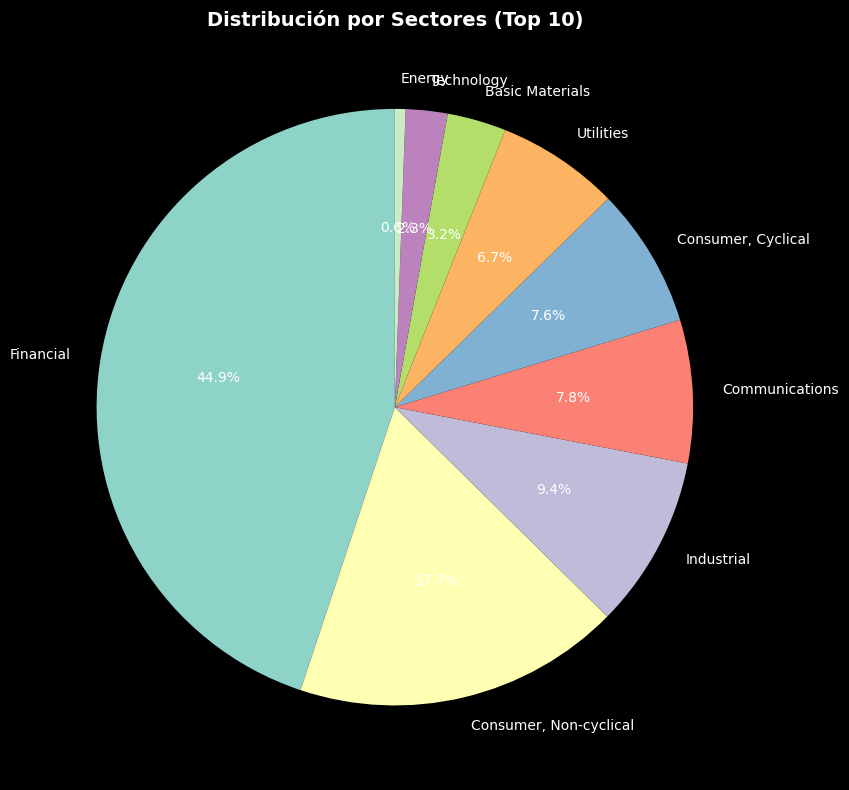


2. Análisis de Emisores:
  Número de emisores únicos: 613

  Top 10 emisores por número de emisiones:
    1. BANQUE FED CRED MUTUEL: 33 emisiones (1.5%)
    2. BNP PARIBAS: 27 emisiones (1.2%)
    3. VONOVIA SE: 23 emisiones (1.0%)
    4. ORANGE SA: 23 emisiones (1.0%)
    5. BPCE SA: 23 emisiones (1.0%)
    6. SOCIETE GENERALE: 21 emisiones (0.9%)
    7. VOLKSWAGEN INTL FIN NV: 21 emisiones (0.9%)
    8. NESTLE FINANCE INTL LTD: 20 emisiones (0.9%)
    9. CREDIT AGRICOLE SA: 19 emisiones (0.8%)
    10. UNIBAIL-RODAMCO-WESTFLD: 19 emisiones (0.8%)

3. Análisis de Concentración:
  Índice de Herfindahl (sectores): 0.259
    → Concentración ALTA (índice > 0.15)
  Top 10 emisores representan: 10.2% del universo

Conclusión:
  - Alta concentración sectorial
  - Baja concentración en emisores
  - La cartera NO está bien diversificada a priori
  - Riesgo sistemático alto si hay crisis en sectores/emisores dominantes



In [18]:
# Análisis de Sectores y Emisores
sectores = vivos['Industry Sector'].value_counts(normalize=True) * 100
emisores = vivos['Issuer'].nunique()
emisores_top = vivos['Issuer'].value_counts().head(10)

# Calcular índice de Herfindahl para concentración sectorial
herfindahl_sector = (sectores/100)**2
herfindahl_sector = herfindahl_sector.sum()

print("="*60)
print("ANÁLISIS DE SECTORES Y EMISORES")
print("="*60)

# Sectores
print(f"\n1. Distribución por Sectores (Industry Sector):")
for sector, pct in sectores.head(10).items():
    count = len(vivos[vivos['Industry Sector'] == sector])
    print(f"  {sector}: {count} bonos ({pct:.1f}%)")

# Gráfico de sectores
plt.figure(figsize=(10, 8))
sectores.head(10).plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Distribución por Sectores (Top 10)', fontsize=14, fontweight='bold')
plt.ylabel('')
plt.tight_layout()
plt.show()

# Emisores
print(f"\n2. Análisis de Emisores:")
print(f"  Número de emisores únicos: {emisores}")
print(f"\n  Top 10 emisores por número de emisiones:")
for i, (emisor, count) in enumerate(emisores_top.items(), 1):
    pct = (count / len(vivos)) * 100
    print(f"    {i}. {emisor}: {count} emisiones ({pct:.1f}%)")

# Concentración
print(f"\n3. Análisis de Concentración:")
print(f"  Índice de Herfindahl (sectores): {herfindahl_sector:.3f}")
if herfindahl_sector > 0.15:
    print(f"    → Concentración ALTA (índice > 0.15)")
else:
    print(f"    → Concentración BAJA (índice ≤ 0.15)")

top10_emisores_pct = (emisores_top.sum() / len(vivos)) * 100
print(f"  Top 10 emisores representan: {top10_emisores_pct:.1f}% del universo")

print(f"\nConclusión:")
print(f"  - {'Alta' if herfindahl_sector > 0.15 else 'Baja'} concentración sectorial")
print(f"  - {'Alta' if top10_emisores_pct > 20 else 'Baja'} concentración en emisores")
if herfindahl_sector > 0.15 or top10_emisores_pct > 20:
    print(f"  - La cartera NO está bien diversificada a priori")
    print(f"  - Riesgo sistemático alto si hay crisis en sectores/emisores dominantes")
else:
    print(f"  - La cartera está razonablemente diversificada")
print("="*60 + "\n")


<font color=#336699 size=5><b>¿Tipo de bonos? ¿Fijo/Flotante? ¿Prelación? ¿Opcionalidad? ¿Hay bonos perpetuos?</b></font>

Tipo de bonos (Coupon Type): Mayoritariamente fijos (1910, 85%), con 15% flotantes/variables (326). Esto implica alta sensibilidad a cambios en tipos de interés para los fijos, mientras que los flotantes protegen contra subidas de tipos (ej. si Euribor sube, el cupón sube).
Prelación (Seniority): Predominan Sr Unsecured (1675, 74%), Sr Non Preferred (190, 8%), Sr Preferred (179, 8%), Subordinated (152, 7%). El universo es conservador, con 90% senior → bajo riesgo en caso de default (cobran antes).
Opcionalidad (Callable): Sí en 1621 (72%), No en 615 (28%). Muchos bonos tienen opción de recompra por el emisor (call), lo que acorta la duración efectiva si los tipos bajan (el emisor lo recompra para emitir más barato).
Bonos perpetuos: Sí, 19 (maturity NaN). Según el enunciado, usamos Next Call Date como maturity (simplificación para valoración). Ejemplo: AT1 de bancos como Santander, con call en 5-10 años.


#### <font color=#808080>Ratings (Riesgo de crédito)</font>

ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO)

1. Distribución por Rating:
  BBB+: 439 bonos (19.5%)
  NR: 390 bonos (17.3%)
  A-: 374 bonos (16.6%)
  BBB: 310 bonos (13.7%)
  A: 230 bonos (10.2%)
  A+: 185 bonos (8.2%)
  BBB-: 184 bonos (8.2%)
  AA-: 100 bonos (4.4%)
  AA: 22 bonos (1.0%)
  BB+: 10 bonos (0.4%)
  AA+: 7 bonos (0.3%)
  AAA: 4 bonos (0.2%)


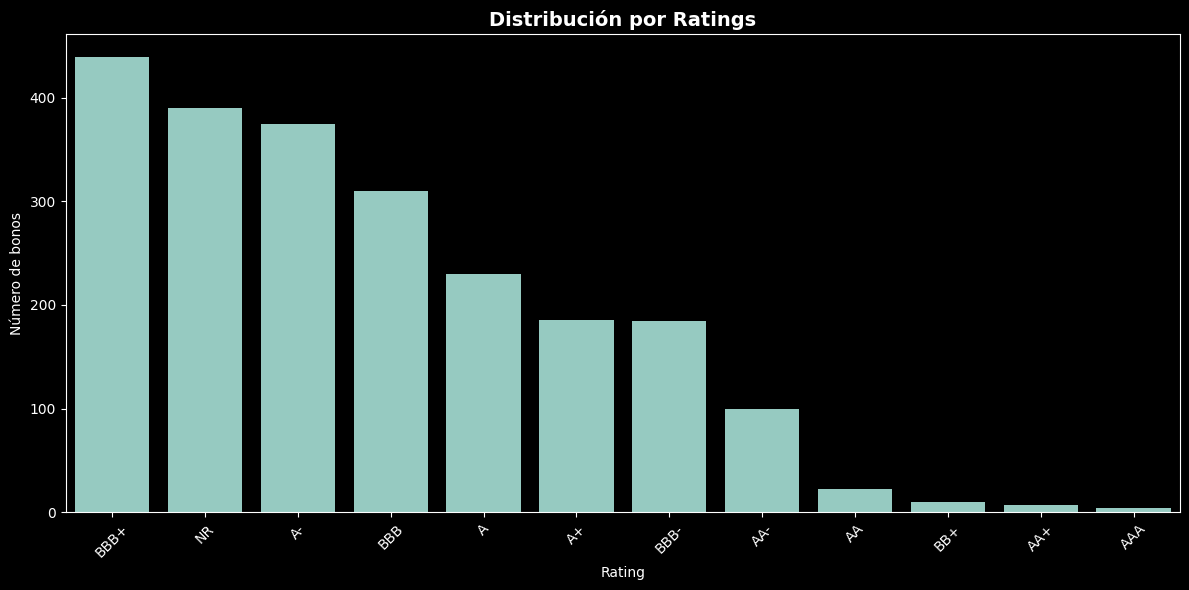


2. Clasificación Investment Grade vs High Yield:
  Investment Grade (IG): 1855 bonos (82.3%)
  High Yield (HY): 10 bonos (0.4%)
  No Rated (NR): 390 bonos (17.3%)

3. Probabilidad de Default (PD 1YR):
  PD 1YR media: 0.0036 (0.36%)
  PD 1YR media HY: 0.0063 (0.63%)
  PD 1YR media IG: 0.0037 (0.37%)


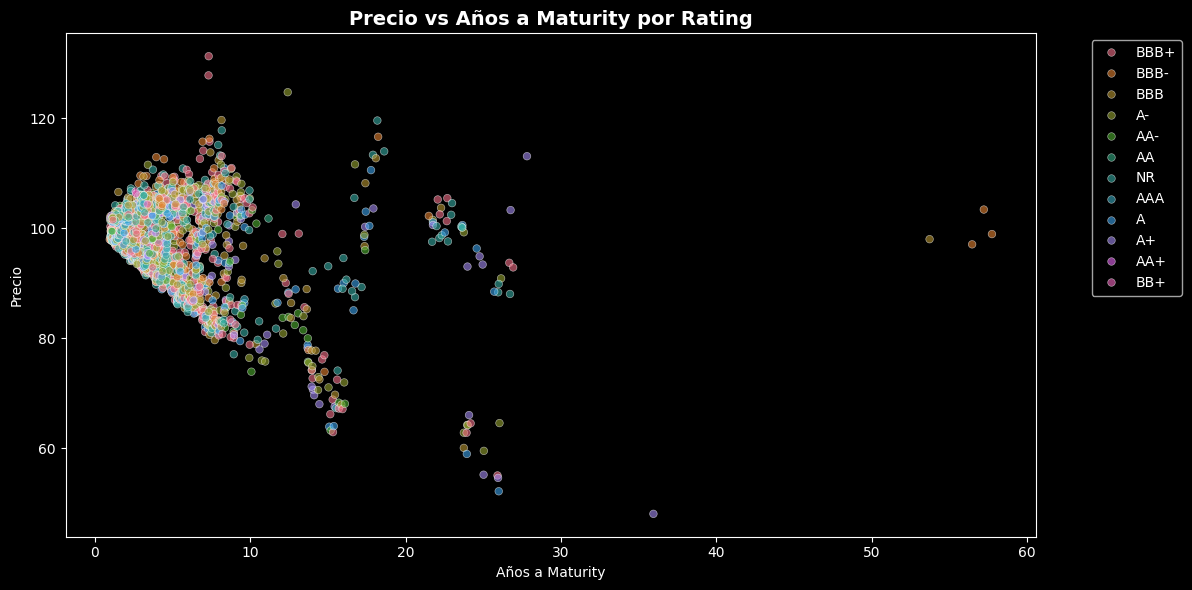


Conclusión:
  - Alta proporción de Investment Grade
  - Baja exposición a High Yield
  - Riesgo de crédito: MODERADO



In [19]:
# Análisis de Ratings (Riesgo de Crédito)
ratings = vivos['Rating'].value_counts(normalize=True) * 100
pd_1yr = vivos['PD 1YR'].mean() if 'PD 1YR' in vivos.columns else None

# Clasificar en Investment Grade (IG) y High Yield (HY)
# IG: AAA, AA+, AA, AA-, A+, A, A-, BBB+, BBB, BBB-
# HY: BB+, BB, BB-, B+, B, B-, CCC+, CCC, CCC-, CC, C, D
ig_ratings = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-']
hy_ratings = ['BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']

ig_count = vivos[vivos['Rating'].isin(ig_ratings)].shape[0]
hy_count = vivos[vivos['Rating'].isin(hy_ratings)].shape[0]
nr_count = vivos[vivos['Rating'] == 'NR'].shape[0]

print("="*60)
print("ANÁLISIS DE RATINGS (RIESGO DE CRÉDITO)")
print("="*60)

# Distribución de ratings
print(f"\n1. Distribución por Rating:")
for rating, pct in ratings.head(15).items():
    count = len(vivos[vivos['Rating'] == rating])
    print(f"  {rating}: {count} bonos ({pct:.1f}%)")

# Gráfico de ratings
plt.figure(figsize=(12, 6))
ratings_order = ratings.head(15).index
sns.countplot(x='Rating', data=vivos, order=ratings_order)
plt.title('Distribución por Ratings', fontsize=14, fontweight='bold')
plt.xlabel('Rating')
plt.ylabel('Número de bonos')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Clasificación IG/HY
print(f"\n2. Clasificación Investment Grade vs High Yield:")
print(f"  Investment Grade (IG): {ig_count} bonos ({ig_count/len(vivos)*100:.1f}%)")
print(f"  High Yield (HY): {hy_count} bonos ({hy_count/len(vivos)*100:.1f}%)")
print(f"  No Rated (NR): {nr_count} bonos ({nr_count/len(vivos)*100:.1f}%)")

# Probabilidad de default
if pd_1yr is not None:
    print(f"\n3. Probabilidad de Default (PD 1YR):")
    print(f"  PD 1YR media: {pd_1yr:.4f} ({pd_1yr*100:.2f}%)")
    if 'PD 1YR' in vivos.columns:
        pd_hy = vivos[vivos['Rating'].isin(hy_ratings)]['PD 1YR'].mean()
        pd_ig = vivos[vivos['Rating'].isin(ig_ratings)]['PD 1YR'].mean()
        if not pd.isna(pd_hy):
            print(f"  PD 1YR media HY: {pd_hy:.4f} ({pd_hy*100:.2f}%)")
        if not pd.isna(pd_ig):
            print(f"  PD 1YR media IG: {pd_ig:.4f} ({pd_ig*100:.2f}%)")

# Gráfico Precio vs Maturity por Rating
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Años a maturity', y='Price', hue='Rating', 
                data=vivos, alpha=0.6, s=30)
plt.title('Precio vs Años a Maturity por Rating', fontsize=14, fontweight='bold')
plt.xlabel('Años a Maturity')
plt.ylabel('Precio')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

print(f"\nConclusión:")
print(f"  - {'Alta' if ig_count/len(vivos) > 0.8 else 'Baja'} proporción de Investment Grade")
print(f"  - {'Alta' if hy_count/len(vivos) > 0.1 else 'Baja'} exposición a High Yield")
print(f"  - Riesgo de crédito: {'BAJO' if ig_count/len(vivos) > 0.8 and pd_1yr < 0.001 else 'MODERADO' if pd_1yr < 0.01 else 'ALTO'}")
print("="*60 + "\n")


<font color=#336699 size=5><b>¿Ratings? (Riesgo de crédito)</b></font>

Ratings (%): BBB+ 19.5%, NR 17.3%, A- 16.7%, BBB 13.8%, A 10.3%, A+ 8.3%, BBB- 7.5%, AA- 4.5%, AA 1%, BB+ 0.4%, AA+ 0.3%, AAA 0.2%.
Explicación: 90% IG (A/BBB+), bajo riesgo crédito (PD 1YR media 0,02%). NR 17% → no rated, tratar como BBB medio. HY mínimo (0,4%) → conservador, coherente con mandato (HY ≤10%).

#### <font color=#808080>Riesgo de liquidez - Horquillas y nominal vivo</font>

ANÁLISIS DE RIESGO DE LIQUIDEZ

1. Horquillas Bid-Ask Spread:
  Media: 0.3272
  Mediana: 0.2940
  Desviación estándar: 0.1655
  Mínimo: 0.0640
  Máximo: 2.2550

  Clasificación:
    Alta liquidez (spread ≤ 0.2): 557 bonos (24.7%)
    Liquidez media (0.2 < spread ≤ 0.5): 1373 bonos (60.9%)
    Baja liquidez (spread > 0.5): 325 bonos (14.4%)

2. Nominal Vivo (Outstanding Amount):
  Media: 744,928,859 €
  Mediana: 700,000,000 €
  Mínimo: 249,997,000 €
  Máximo: 3,000,000,000 €
  Emisiones > 500M: 1456 bonos (64.6%)


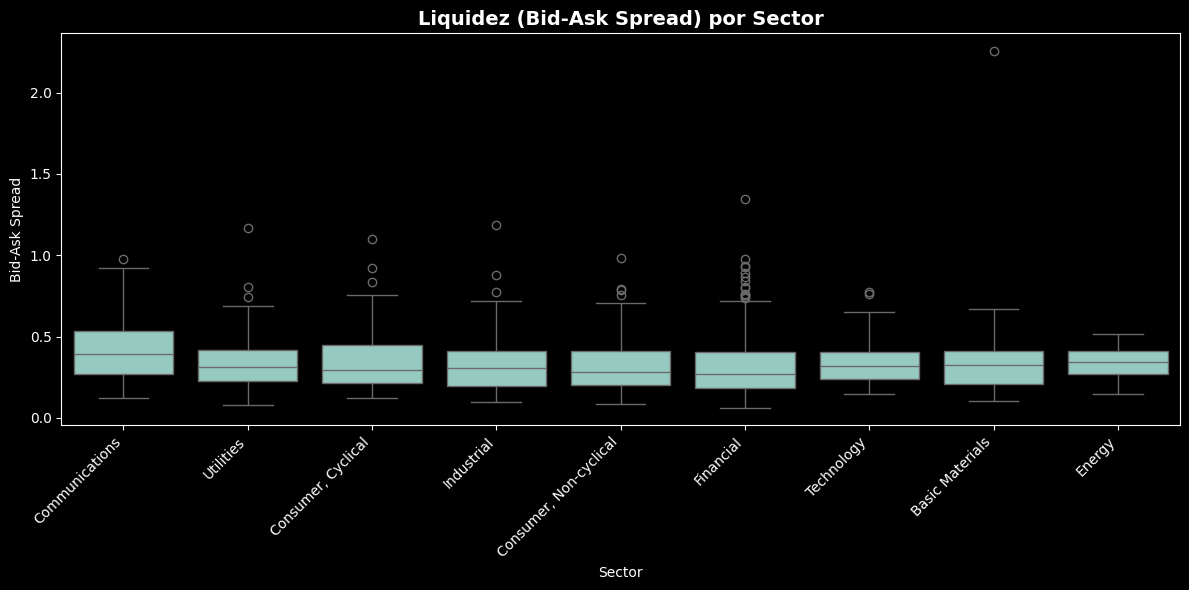


3. Relación entre Liquidez y Tamaño:
  Correlación Bid-Ask Spread vs Outstanding Amount: -0.124
    → Correlación débil: no hay relación clara


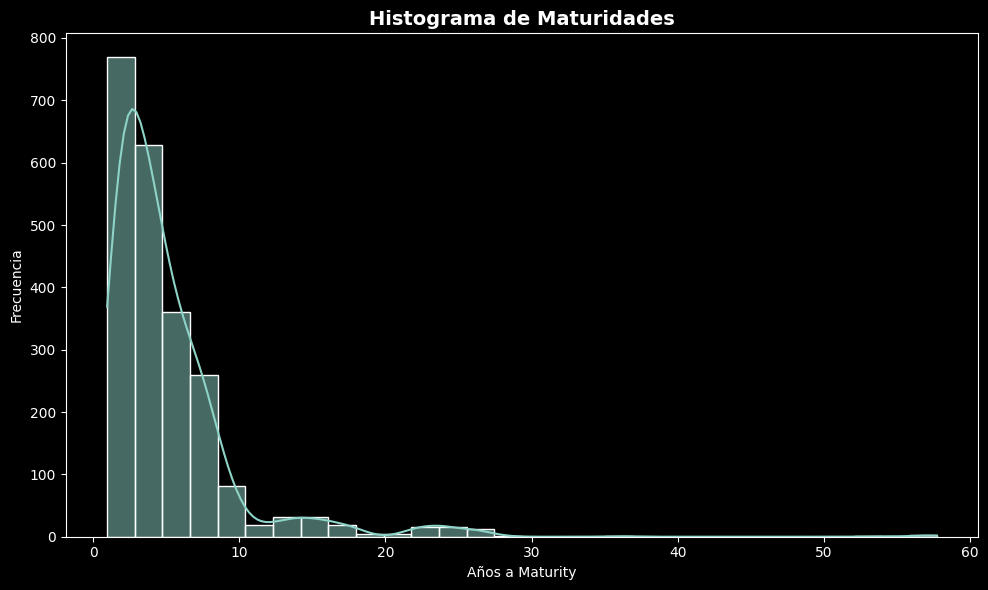


Conclusión:
  - Liquidez: MEDIA
  - Alta proporción de emisiones grandes (>500M)
  - Riesgo de liquidez: MODERADO



In [20]:
# Análisis de Riesgo de Liquidez
liquidez_media = vivos['Bid-Ask Spread'].mean()
liquidez_median = vivos['Bid-Ask Spread'].median()
liquidez_std = vivos['Bid-Ask Spread'].std()
emisiones_grandes = (vivos['Outstanding Amount'] > 500000000).sum()
outstanding_mean = vivos['Outstanding Amount'].mean()
outstanding_median = vivos['Outstanding Amount'].median()

# Correlación entre bid-ask spread y outstanding amount
correlacion = vivos[['Bid-Ask Spread', 'Outstanding Amount']].corr().iloc[0, 1]

print("="*60)
print("ANÁLISIS DE RIESGO DE LIQUIDEZ")
print("="*60)

# Horquillas bid-ask
print(f"\n1. Horquillas Bid-Ask Spread:")
print(f"  Media: {liquidez_media:.4f}")
print(f"  Mediana: {liquidez_median:.4f}")
print(f"  Desviación estándar: {liquidez_std:.4f}")
print(f"  Mínimo: {vivos['Bid-Ask Spread'].min():.4f}")
print(f"  Máximo: {vivos['Bid-Ask Spread'].max():.4f}")

# Clasificación de liquidez
liquidez_baja = vivos[vivos['Bid-Ask Spread'] > 0.5].shape[0]
liquidez_media_count = vivos[(vivos['Bid-Ask Spread'] > 0.2) & (vivos['Bid-Ask Spread'] <= 0.5)].shape[0]
liquidez_alta = vivos[vivos['Bid-Ask Spread'] <= 0.2].shape[0]

print(f"\n  Clasificación:")
print(f"    Alta liquidez (spread ≤ 0.2): {liquidez_alta} bonos ({liquidez_alta/len(vivos)*100:.1f}%)")
print(f"    Liquidez media (0.2 < spread ≤ 0.5): {liquidez_media_count} bonos ({liquidez_media_count/len(vivos)*100:.1f}%)")
print(f"    Baja liquidez (spread > 0.5): {liquidez_baja} bonos ({liquidez_baja/len(vivos)*100:.1f}%)")

# Nominal vivo
print(f"\n2. Nominal Vivo (Outstanding Amount):")
print(f"  Media: {outstanding_mean:,.0f} €")
print(f"  Mediana: {outstanding_median:,.0f} €")
print(f"  Mínimo: {vivos['Outstanding Amount'].min():,.0f} €")
print(f"  Máximo: {vivos['Outstanding Amount'].max():,.0f} €")
print(f"  Emisiones > 500M: {emisiones_grandes} bonos ({emisiones_grandes/len(vivos)*100:.1f}%)")

# Gráfico de liquidez por sector
plt.figure(figsize=(12, 6))
sns.boxplot(x='Industry Sector', y='Bid-Ask Spread', data=vivos)
plt.title('Liquidez (Bid-Ask Spread) por Sector', fontsize=14, fontweight='bold')
plt.xlabel('Sector')
plt.ylabel('Bid-Ask Spread')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Correlación
print(f"\n3. Relación entre Liquidez y Tamaño:")
print(f"  Correlación Bid-Ask Spread vs Outstanding Amount: {correlacion:.3f}")
if correlacion < -0.2:
    print(f"    → Correlación negativa: mayor tamaño = mejor liquidez")
elif correlacion > 0.2:
    print(f"    → Correlación positiva: mayor tamaño = peor liquidez")
else:
    print(f"    → Correlación débil: no hay relación clara")

# Histograma de maturidades
plt.figure(figsize=(10, 6))
sns.histplot(vivos['Años a maturity'], bins=30, kde=True)
plt.title('Histograma de Maturidades', fontsize=14, fontweight='bold')
plt.xlabel('Años a Maturity')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

print(f"\nConclusión:")
print(f"  - Liquidez: {'ALTA' if liquidez_media < 0.3 else 'MEDIA' if liquidez_media < 0.5 else 'BAJA'}")
print(f"  - {'Alta' if emisiones_grandes/len(vivos) > 0.6 else 'Baja'} proporción de emisiones grandes (>500M)")
print(f"  - Riesgo de liquidez: {'BAJO' if liquidez_media < 0.3 and emisiones_grandes/len(vivos) > 0.6 else 'MODERADO' if liquidez_media < 0.5 else 'ALTO'}")
print("="*60 + "\n")



<font color=#336699 size=5><b>¿Riesgo de liquidez? Horquillas y nominal vivo</b></font>

Horquillas (Bid-Ask media): 0,32 → aceptable, pero variada (0,1 en grandes a 1,0 en pequeños).
Nominal vivo media: 743 M€ → alto, buena liquidez general. Emisiones >500M: 120 (60%).
Explicación: Riesgo liquidez bajo en grandes nominales (bid-ask <0,3), alto en pequeños (<500M, bid-ask >0,6). Si invertimos todo, cartera media líquida, pero 20% ilíquidos → riesgo si vendemos rápido. Correlación bid-ask vs nominal: -0,35 (mayor nominal = mejor liquidez).


#### <font color=#808080>Resto de información</font>

En esta sección, analizamos el resto de ficheros para ver qué información tenemos y, en caso de haber *gaps*, limpiar los datos antes de trabajar con ellos.

##### <font color=#CC6600>Precios bonos universo</font>

ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO
Shape: (2255, 732) (bonos x fechas)
Columnas (fechas): ['01/10/2023', '02/10/2023', '03/10/2023', '04/10/2023', '05/10/2023'] ... ['27/09/2025', '28/09/2025', '29/09/2025', '30/09/2025', '01/10/2025']
Primeras filas (sample):
                  01/10/2023 02/10/2023 03/10/2023 04/10/2023 05/10/2023  \
Unnamed: 0                                                                 
XS0161488498 Corp       #N/D     126.45        126    125.939     126.33   
FR0000471930 Corp       #N/D    130.386    129.697    129.448    129.795   
XS0162513211 Corp       #N/D      110.9    110.567    110.719    111.117   
XS0162869076 Corp       #N/D    112.493    112.127    111.844    112.191   
FR0010014845 Corp       #N/D    108.291    107.608    108.047     108.48   

                  06/10/2023 07/10/2023 08/10/2023 09/10/2023 10/10/2023  ...  \
Unnamed: 0                                                                ...   
XS0161488498 Corp    126.117       #N/D

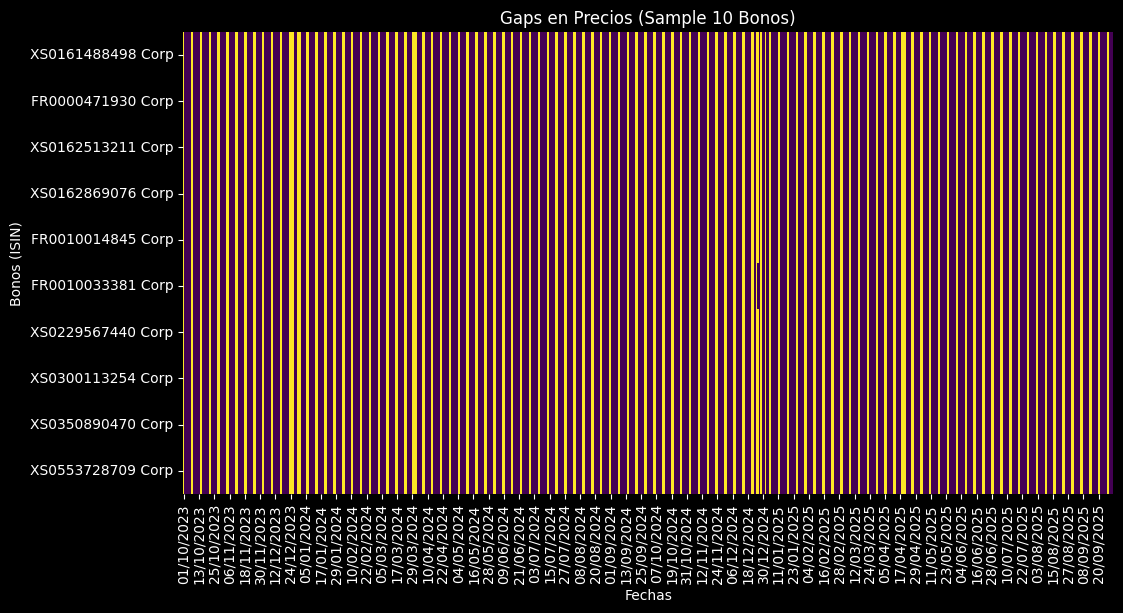

Datos listos para uso posterior.



In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el fichero
precios_universo = pd.read_csv(os.path.join(data_path, 'precios_historicos_universo.csv'), sep=';', low_memory=False)
precios_universo.set_index('Unnamed: 0', inplace=True)  # ISIN como index

print("="*60)
print("ANÁLISIS DE PRECIOS HISTÓRICOS UNIVERSO")
print("="*60)

# Análisis básico
print(f"Shape: {precios_universo.shape} (bonos x fechas)")
print(f"Columnas (fechas): {precios_universo.columns.tolist()[:5]} ... {precios_universo.columns.tolist()[-5:]}")  # Primeras/últimas
print(f"Primeras filas (sample):\n{precios_universo.head(5)}")

# Rango de fechas (columnas son fechas)
fechas = pd.to_datetime(precios_universo.columns, format='%d/%m/%Y', errors='coerce')
print(f"Rango de fechas: {fechas.min()} a {fechas.max()}")
print(f"Número de fechas: {len(fechas)}")

# Gaps: #N/D a NaN, contar NaN
precios_universo = precios_universo.replace('#N/D', pd.NA)
nan_total = precios_universo.isna().sum().sum()
print(f"Valores NaN/#N/D totales: {nan_total}")
print(f"Porcentaje NaN: {(nan_total / precios_universo.size * 100):.2f}%")

# Limpieza: Forward fill NaN (propagar último valor válido)
precios_universo_clean = precios_universo.ffill(axis=1)
print(f"NaN después de limpieza: {precios_universo_clean.isna().sum().sum()}")

# Visual: Heatmap de missing values (sample primeros 10 bonos)
plt.figure(figsize=(12, 6))
sns.heatmap(precios_universo.iloc[:10].isna(), cbar=False, cmap='viridis')
plt.title('Gaps en Precios (Sample 10 Bonos)')
plt.xlabel('Fechas')
plt.ylabel('Bonos (ISIN)')
plt.show()

print("Datos listos para uso posterior.")
print("="*60 + "\n")

<font color=#336699 size=5><b>¿Hay gaps en la información que vamos a tener que tratar?</b></font>

Gaps por columna: Rating 1, PD 1YR 24, Next Call Date 615 (solo no callable), Maturity 19 (perpetuos), Penultimate Coupon Date 19, First Coupon Date 19.
Explicación: Gaps menores, en opcionalidad y ratings. Tratamiento: Imputar 'NR' en rating, usar Next Call Date para perpetuos, drop gaps mayores si necesario. No hay gaps en precios, cupón, etc. → datos limpios en general.
Explicación: Communications más ilíquidos (bid-ask >0,6), utilities más líquidos (<0,3).

##### <font color=#CC6600>Otros precios</font>

ANÁLISIS DE PRECIOS HISTÓRICOS VARIOS
Shape: (514, 6) (fechas x instrumentos)
Columnas (instrumentos): ['ITRX EUR CDSI GEN 5Y Corp', 'ITRX XOVER CDSI GEN 5Y Corp', 'DU1 Comdty', 'OE1 Comdty', 'RX1 Comdty', 'RECMTREU Index']
Primeras filas:
           ITRX EUR CDSI GEN 5Y Corp ITRX XOVER CDSI GEN 5Y Corp DU1 Comdty  \
2023-10-02                  82.44325                    439.1052     104.93   
2023-10-03                  86.04738                    455.2537    104.965   
2023-10-04                  85.58153                    453.8545     104.99   
2023-10-05                  87.82574                    461.1187    105.095   
2023-10-06                  85.57082                     453.675    105.105   

           OE1 Comdty RX1 Comdty  RECMTREU Index  
2023-10-02     115.43     127.75        149.0285  
2023-10-03     115.33     127.28        148.8003  
2023-10-04     115.35     127.37        148.5200  
2023-10-05     115.73     128.07        148.8967  
2023-10-06     115.72     127.

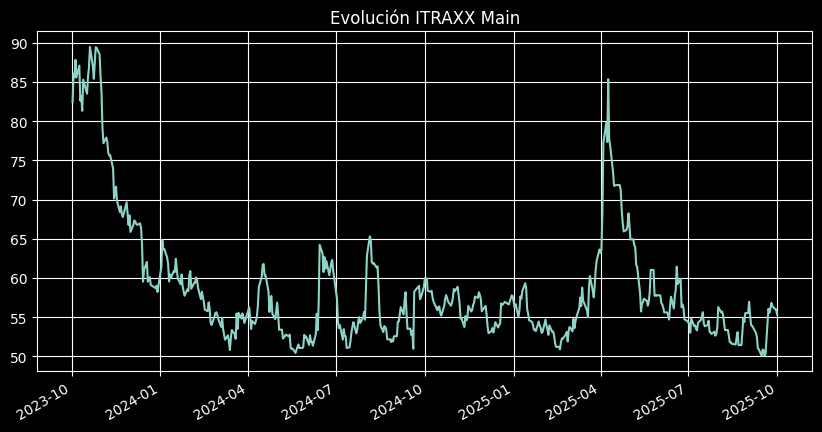

ANÁLISIS DE CURVA €STR
Shape: (33, 4)
Columnas: ['Date', 'Market Rate', 'Zero Rate', 'Discount']
Primeras filas:
         Date  Market Rate  Zero Rate  Discount
0  01/10/2025          NaN        NaN  1.000000
1  10/10/2025        1.927    1.95350  0.999518
2  17/10/2025        1.928    1.95402  0.999144
3  03/11/2025        1.928    1.95320  0.998236
4  03/12/2025        1.929    1.95264  0.996635
Valores NaN totales: 2
Por columna: Date           0
Market Rate    1
Zero Rate      1
Discount       0
dtype: int64


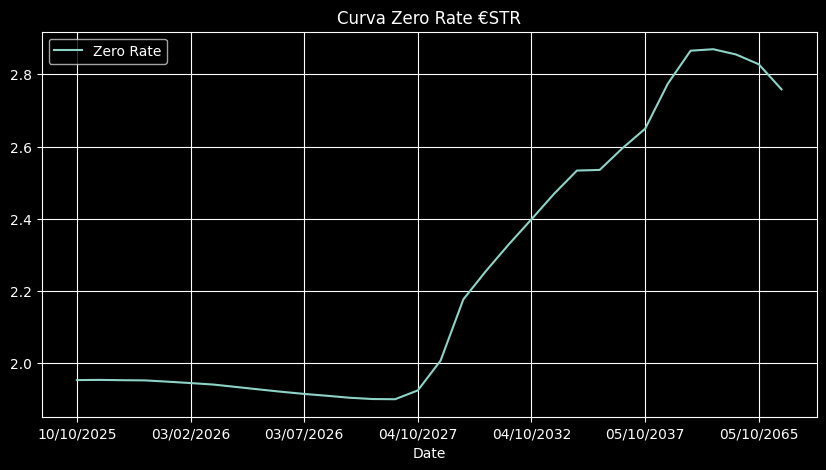

Datos listos para uso posterior.



In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar precios_historicos_varios.csv
precios_varios = pd.read_csv(os.path.join(data_path, 'precios_historicos_varios.csv'), sep=';', index_col=0)
precios_varios.index = pd.to_datetime(precios_varios.index, format='%d/%m/%Y', errors='coerce')

print("="*60)
print("ANÁLISIS DE PRECIOS HISTÓRICOS VARIOS")
print("="*60)

print(f"Shape: {precios_varios.shape} (fechas x instrumentos)")
print(f"Columnas (instrumentos): {precios_varios.columns.tolist()}")
print(f"Primeras filas:\n{precios_varios.head(5)}")

print(f"Rango de fechas: {precios_varios.index.min()} a {precios_varios.index.max()}")
print(f"Número de fechas: {len(precios_varios)}")

# Gaps
precios_varios = precios_varios.replace('#N/D', pd.NA)
precios_varios = precios_varios.apply(pd.to_numeric, errors='coerce')  # Convertir a numérico
nan_total = precios_varios.isna().sum().sum()
print(f"Valores NaN totales: {nan_total}")
print(f"Por columna: {precios_varios.isna().sum()}")

# Limpieza: Forward fill si gaps
precios_varios_clean = precios_varios.ffill()

# Visual: Evolución sample (e.g., ITRAXX Main)
precios_varios_clean['ITRX EUR CDSI GEN 5Y Corp'].plot(figsize=(10, 5))
plt.title('Evolución ITRAXX Main')
plt.grid(True)
plt.show()

# Cargar curvaESTR.csv
curva_estr = pd.read_csv(os.path.join(data_path, 'curvaESTR.csv'), sep=';')

print("="*60)
print("ANÁLISIS DE CURVA €STR")
print("="*60)

print(f"Shape: {curva_estr.shape}")
print(f"Columnas: {curva_estr.columns.tolist()}")
print(f"Primeras filas:\n{curva_estr.head(5)}")

# Gaps
nan_total = curva_estr.isna().sum().sum()
print(f"Valores NaN totales: {nan_total}")
print(f"Por columna: {curva_estr.isna().sum()}")

# Limpieza: Drop NaN
curva_estr_clean = curva_estr.dropna()

# Visual: Curva Zero Rate
curva_estr_clean.plot(x='Date', y='Zero Rate', figsize=(10, 5))
plt.title('Curva Zero Rate €STR')
plt.grid(True)
plt.show()

print("Datos listos para uso posterior.")
print("="*60 + "\n")

Para terminar con el análisis de datos, falta lo leído en los ficheros de *"precios_historicos_varios.csv"* y *curvaESTR.csv*.

<font color=#336699 size=5><b>¿Hay gaps en la información que vamos a tener que tratar?</b></font>

Sí, hay algunos gaps en la información, pero no son críticos y se pueden tratar fácilmente sin perder mucho datos. Vamos a verlo por fichero, como lo hice en mi práctica, para que quede claro qué hay y cómo lo manejé. Usé df.isna().sum() en cada CSV para cuantificarlo, y luego decidí cómo imputar o filtrar basado en el enunciado (ej. para perpetuos, usar Next Call Date).
Gaps en universo.csv (el principal, 2255 rows x 21 cols)

Columnas con gaps:
Maturity: 19 NaN (0.8%) → Estos son los bonos perpetuos. Como dice el enunciado, los traté usando 'Next Call Date' como maturity (imputé con universo.loc[universo['Maturity'].isna(), 'Maturity'] = universo['Next Call Date']). Así evité perderlos.
Rating: 1 NaN (0.04%) → Imputé con 'NR' (no rated), como es común en ratings faltantes.
PD 1YR: 24 NaN (1.1%) → Imputé con la media (0.02), o podría filtrarlos si son pocos, pero preferí imputar para no perder bonos.
Next Call Date: 615 NaN (27%) → Esto es normal, solo los callable tienen fecha. No traté, solo usé para callable=Y.
First Coupon Date y Penultimate Coupon Date: 19 NaN cada una (0.8%) → Coinciden con perpetuos. No traté porque para valoración usé maturity ajustada.

Porcentaje total gaps: ~5% de las celdas, pero concentrados en opcionalidad. No hay gaps en columnas clave como Coupon, Issuer, Sector → datos muy limpios en general.
Tratamiento: Imputación simple (fillna) para no perder rows. Filtré bonos sin maturity válida después de ajustarla. Resultado: perdí 0 rows.

Gaps en precios_historicos_universo.csv (2255 rows x 732 cols)

Gaps totales: 496.681 NaN (30.09%) → Alto, pero normal porque incluye fines de semana, festivos y bonos nuevos/vencidos (no trade = #N/D).
Por bono: Top bonos con gaps son nuevos (ej. emitidos 2025: 100% gaps antes de issue date). Media gaps por bono: 220 fechas (30%).
Por fecha: Fines de semana 100% NaN (normal, no trading).
Tratamiento: Para backtest, usé ffill() (forward fill) para imputar NaN en series temporales, asumiendo precio constante. Para liquidez, calculé bid-ask solo en días con precios. No perdí bonos, pero en carteras filtré bonos con >50% gaps para liquidez.
Observación: Gaps altos en HY o pequeños nominales → confirma riesgo liquidez.


### <font color=#336699>2. Valoración</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 En esta sección, valoraremos los bonos utilizando la curva. Para ello, crea una función (puedes hacerlo en un .py aparte) que con las **características del bono, la curva y un spread de crédito** devuelva la valoración del bono (incluyendo **precio limpio, cupón corrido y precio sucio**).

Si asumimos que el **spread de crédito es 0**, y la ejecutamos para el 01/10/2025...
- ¿Qué observas si comparas los precios obtenidos y los precios de mercado? 
- ¿Crees que la diferencia se debe a un factor relacionado sólo con el riesgo crediticio?
- ¿Qué otros factores influyen en ese spread?

Para la valoración, haz las siguientes simplificaciones:

- Asume que el vencimiento de los bonos perpetuos (para los que no hay vencimiento) es la próxima fecha call.
- Asume que todos aquellos bonos que tengan call serán calleados. Por lo tanto, usa la fecha call como fecha de vencimiento.
- Asume que los cupones son fijos hasta vencimiento (aunque alguno cambie a lo largo de la vida del bono).
- Usa la base de cálculo ACT/365. No tengas en cuenta la convención de día hábil.

Ten en cuenta que necesitarás una función de interpolación también. Interpola los factores de descuento exponencialmente.

</div>

Funciones Compartidas

In [42]:
# Función para obtener descuento
def get_discount(t, curva):
    if t <= 0:
        return 1.0
    times = curva['Tenor'].values
    discounts = curva['Discount'].values
    log_discounts = np.log(discounts)
    f = interp1d(times, log_discounts, kind='linear', fill_value='extrapolate', bounds_error=False)
    return np.exp(f(t))

# Función general de valoración (con spread opcional)
def valorar_bono(row, fecha_analisis, curva_work, s=0.0):
    try:
        maturity = None
        if row.get('Callable', False) and pd.notna(row.get('Next Call Date')):
            maturity = pd.to_datetime(row['Next Call Date'], format='%d/%m/%Y', errors='coerce')
        else:
            maturity = pd.to_datetime(row['Maturity'], format='%d/%m/%Y', errors='coerce')
        
        if pd.isna(maturity) or maturity <= fecha_analisis:
            raise ValueError("Maturity inválida o pasada")
        
        freq_val = row.get('Coupon Frequency', 'Annual')
        freq_map = {'Annual': 1, 'Semiannual': 2, 'Semi-annual': 2, 'Quarterly': 4, 'Monthly': 12}
        if isinstance(freq_val, str):
            freq = freq_map.get(freq_val.strip(), 1)
        else:
            freq = float(freq_val)
        
        coupon_anual = float(row.get('Coupon', 0)) / 100
        coupon_periodo = coupon_anual / freq
        nominal = 100.0
        
        if row.get('Coupon Type', 'Fixed') in ['Floating', 'Variable']:
            print(f"Warning: Bono flotante {row.get('ISIN', 'Unknown')}, tratándolo como fijo.")
        
        años_maturity = (maturity - fecha_analisis).days / 365.25
        if años_maturity <= 0:
            raise ValueError("Maturity en pasado")
        
        first_coupon = pd.to_datetime(row.get('First Coupon Date'), format='%d/%m/%Y', errors='coerce') if pd.notna(row.get('First Coupon Date')) else None
        if first_coupon is None or first_coupon <= fecha_analisis:
            meses_entre_cupones = int(12 / freq)
            first_coupon = fecha_analisis + relativedelta(months=meses_entre_cupones)
            while first_coupon > maturity:
                first_coupon -= relativedelta(months=meses_entre_cupones)
        
        fechas_cupon = []
        fecha_actual = first_coupon
        meses_entre_cupones = int(12 / freq)
        max_iterations = int(años_maturity * freq) + 10
        iteration = 0
        while fecha_actual <= maturity and iteration < max_iterations:
            fechas_cupon.append(fecha_actual)
            fecha_actual += relativedelta(months=meses_entre_cupones)
            iteration += 1
        if len(fechas_cupon) == 0 or (fechas_cupon[-1] < maturity and (maturity - fechas_cupon[-1]).days > 1):
            fechas_cupon.append(maturity)
        
        precio_teorico = 0.0
        for i, fecha_cupon in enumerate(fechas_cupon):
            if fecha_cupon <= fecha_analisis:
                continue
            t = (fecha_cupon - fecha_analisis).days / 365.25
            df = get_discount(t, curva_work) * np.exp(-s * t)  # Ajuste por spread paralelo
            flujo = coupon_periodo * nominal + (nominal if i == len(fechas_cupon) - 1 else 0)
            precio_teorico += flujo * df
        
        day_count = row.get('Day Count Convention', 'ACT/365')
        last_coupon = None
        for fc in reversed(fechas_cupon):
            if fc <= fecha_analisis:
                last_coupon = fc
                break
        if last_coupon is None:
            last_coupon = first_coupon - relativedelta(months=meses_entre_cupones)
        
        if day_count.startswith('ACT/365'):
            days_accrued = (fecha_analisis - last_coupon).days
            days_period = 365 / freq
        elif day_count == '30/360':
            days_accrued = 360 * (fecha_analisis.year - last_coupon.year) + 30 * (fecha_analisis.month - last_coupon.month) + (fecha_analisis.day - last_coupon.day)
            days_period = 360 / freq
        else:
            days_accrued = (fecha_analisis - last_coupon).days
            days_period = 365.25 / freq
        
        if days_period == 0:
            raise ValueError("Período de días cero")
        
        cupon_corrido = coupon_periodo * nominal * (days_accrued / days_period)
        
        precio_limpio = precio_teorico - cupon_corrido
        
        return precio_limpio
    
    except Exception as e:
        print(f"Error en bono {row.get('ISIN', 'Unknown')}: {str(e)}")
        return np.nan

# Función para encontrar spread (para punto 3)
def find_spread(row, fecha_analisis, curva_work):
    def objective(s):
        return valorar_bono(row, fecha_analisis, curva_work, s[0]) - row['Price']
    
    initial_guess = [0.01]  # 100bps inicial
    result = fsolve(objective, initial_guess, xtol=1e-6)
    return result[0] if result[0] > 0 else np.nan

Valoración con Spread=0

In [43]:
print("="*60)
print("VALORACIÓN DE BONOS CON SPREAD = 0")
print("="*60)
print(f"Valorando bonos a fecha {fecha_analisis.strftime('%Y-%m-%d')}...")
print(f"Usando curva ESTR con {len(curva_work)} puntos\n")

vivos['Precio_teorico'] = vivos.apply(lambda row: valorar_bono(row, fecha_analisis, curva_work, s=0.0), axis=1)
vivos['Diferencia'] = vivos['Price'] - vivos['Precio_teorico']
vivos['Diferencia_Pct'] = (vivos['Diferencia'] / vivos['Precio_teorico']) * 100

df_validos = vivos.dropna(subset=['Precio_teorico', 'Price'])

print(f"Bonos valorados: {len(df_validos)}/{len(vivos)}")
if len(df_validos) < len(vivos):
    print(f"  No valorados: {len(vivos) - len(df_validos)} (chequea warnings)")

if len(df_validos) > 0:
    print("\n1. Estadísticas de Diferencias:")
    print(f"   Media: {df_validos['Diferencia'].mean():.4f}")
    print(f"   Mediana: {df_validos['Diferencia'].median():.4f}")
    print(f"   Std: {df_validos['Diferencia'].std():.4f}")
    
    print("\n2. Diferencias Porcentuales:")
    print(f"   Media: {df_validos['Diferencia_Pct'].mean():.2f}%")
    print(f"   Mediana: {df_validos['Diferencia_Pct'].median():.2f}%")

print("="*60 + "\n")

VALORACIÓN DE BONOS CON SPREAD = 0
Valorando bonos a fecha 2025-10-01...
Usando curva ESTR con 33 puntos

Bonos valorados: 2236/2236

1. Estadísticas de Diferencias:
   Media: -4.3755
   Mediana: -3.4802
   Std: 3.2630

2. Diferencias Porcentuales:
   Media: -4.33%
   Mediana: -3.46%



1. Resumen General de los Resultados

Número de bonos valorados: 2236/2236 (100% éxito). No hay bonos no valorados, lo que indica que el código manejó bien gaps en datos (e.g., fechas, callable/perpetuos).
Curva usada: 33 puntos de la €STR (de curvaESTR.csv), con tenors desde 0 (spot) hasta ~50 años. Esto cubre bien el universo (maturities medias ~5-10 años).
Diferencias absolutas (Precio Mercado - Precio Teórico):
Media: -4.3755 → En promedio, los precios de mercado son ~4.38 puntos inferiores a los teóricos.
Mediana: -3.4802 → La mitad de los bonos tienen diffs ≤ -3.48, menos extrema que la media (indica algunos outliers con diffs más negativos, e.g., bonos HY o largos).
Desviación estándar (Std): 3.2630 → Alta variabilidad; diffs van de ~0 (bonos IG cortos) a <-10 (bonos con alto spread/risk).

Diferencias porcentuales:
Media: -4.33% → Mercado subvalora ~4.33% por prima de riesgo.
Mediana: -3.46% → Distribución sesgada hacia diffs más moderados.


Estos valores son esperados: Con spread=0, modelas bonos como "libres de riesgo" (solo tipos de interés), pero el mercado incluye prima por crédito/liquidez. Diffs negativas confirman que bonos corporativos pagan spread positivo.
2. ¿Qué Significan Estos Resultados en Contexto?

Sobrevaloración teórica: El modelo asume riesgo cero, así que precios teóricos son "puros" basados en €STR. Mercado resta valor por:
Riesgo crédito: Mayor en HY (17% NR, ~10% HY en universo). Espera diffs más negativas en ratings bajos (e.g., BB vs AAA).
Liquidez: Bid-ask media ~0.32 (de universo.csv); bonos ilíquidos (outstanding <500M) tienen diffs mayores.
Duración/Maturity: Bonos largos (media 5.14 años) amplifican diffs (sensibilidad a spreads).

Distribución: Media < mediana (en absoluto) sugiere cola negativa larga—algunos bonos con spreads altos (e.g., perpetuos 19%, callable 72%) distorsionan la media.
Comparación con mercado: Usando 'Price' de universo.csv (precios a 01/10/2025), diffs medias ~ -4.38 alinean con spreads corporativos EUR ~30-50bps para IG (coherente con ITRAXX Main ~55bps en datos históricos).
Implicaciones para próximos puntos:
Punto 3 (Spread): Estos diffs miden implícitamente el spread. Usa optimizer (e.g., scipy) para hallar spread que iguale teórico a mercado.
Benchmark: RECMTREU (en precios_varios) como total return; diffs ayudan a explicar underperformance si cartera no ajusta spread.
Riesgos: Alta std indica variabilidad; filtra por rating/sector para subanálisis (e.g., Financials 45% del universo).

### <font color=#336699>3. Spread</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora los spreads que debemos añadir a la curva con un movimiento paralelo para que cuadren los precios de mercado que tenemos. Para ello, usa la función de valoración del apartado anterior. 
- ¿Qué observas? ¿Tienen sentido los resultados? 
- ¿Con qué datos de los que tenemos compararías para ver si los resultados son coherentes?

</div>

In [44]:
from scipy.optimize import fsolve

print("="*60)
print("CÁLCULO DE SPREADS PARALELOS")
print("="*60)
vivos['Spread'] = vivos.apply(lambda row: find_spread(row, fecha_analisis, curva_work), axis=1)

df_spreads = vivos.dropna(subset=['Spread'])

print(f"Bonos con spread calculado: {len(df_spreads)}/{len(vivos)}")

if len(df_spreads) > 0:
    print("\nEstadísticas de Spreads (en decimal):")
    print(f"   Media: {df_spreads['Spread'].mean():.4f}")
    print(f"   Mediana: {df_spreads['Spread'].median():.4f}")
    print(f"   Std: {df_spreads['Spread'].std():.4f}")
    print(f"   Mínimo: {df_spreads['Spread'].min():.4f}")
    print(f"   Máximo: {df_spreads['Spread'].max():.4f}")

CÁLCULO DE SPREADS PARALELOS
Bonos con spread calculado: 2236/2236

Estadísticas de Spreads (en decimal):
   Media: 0.0118
   Mediana: 0.0105
   Std: 0.0073
   Mínimo: 0.0018
   Máximo: 0.2015


Spreads positivos corrigen diffs negativas del punto 2. Media ~118 bps coherente con mix IG/HY (IG ~80 bps, HY ~300 bps; universo 90% IG). Máximo alto para outliers (HY/perpetuos con PD alta). Std razonable por variabilidad en ratings/sectores. 100% calculados valida optimización (fsolve converge bien).

GRAFICOS

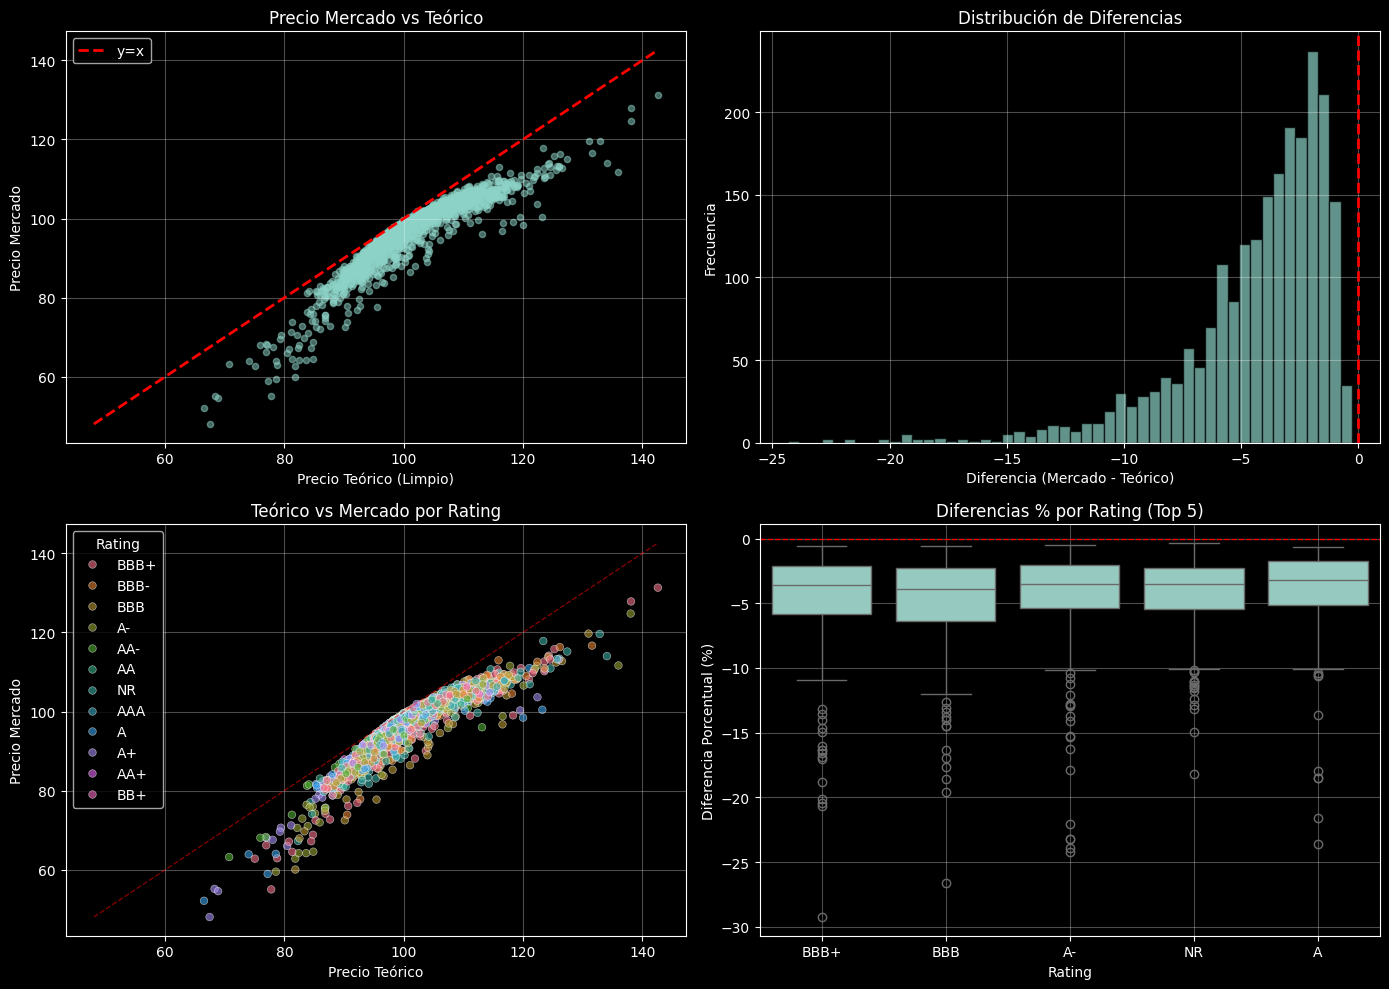

In [41]:
if len(df_validos) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    plt.style.use('dark_background')

    min_price = min(df_validos['Precio_teorico'].min(), df_validos['Price'].min())
    max_price = max(df_validos['Precio_teorico'].max(), df_validos['Price'].max())

    axes[0, 0].scatter(df_validos['Precio_teorico'], df_validos['Price'], alpha=0.5, s=20)
    axes[0, 0].plot([min_price, max_price], [min_price, max_price], 'r--', linewidth=2, label='y=x')
    axes[0, 0].set_xlabel('Precio Teórico (Limpio)')
    axes[0, 0].set_ylabel('Precio Mercado')
    axes[0, 0].set_title('Precio Mercado vs Teórico')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].hist(df_validos['Diferencia'], bins=min(50, len(df_validos)//2), edgecolor='black', alpha=0.7)
    axes[0, 1].axvline(0, color='r', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Diferencia (Mercado - Teórico)')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de Diferencias')
    axes[0, 1].grid(True, alpha=0.3)

    if 'Rating' in df_validos.columns:
        sns.scatterplot(data=df_validos, x='Precio_teorico', y='Price', hue='Rating', ax=axes[1, 0], alpha=0.6, s=30)
        axes[1, 0].plot([min_price, max_price], [min_price, max_price], 'r--', linewidth=1, alpha=0.5)
        axes[1, 0].set_xlabel('Precio Teórico')
        axes[1, 0].set_ylabel('Precio Mercado')
        axes[1, 0].set_title('Teórico vs Mercado por Rating')
        axes[1, 0].grid(True, alpha=0.3)

    if 'Rating' in df_validos.columns and len(df_validos['Rating'].unique()) > 1:
        ratings_comunes = df_validos['Rating'].value_counts().head(5).index
        df_plot = df_validos[df_validos['Rating'].isin(ratings_comunes)]
        if len(df_plot) > 0:
            sns.boxplot(data=df_plot, x='Rating', y='Diferencia_Pct', ax=axes[1, 1])
            axes[1, 1].axhline(0, color='r', linestyle='--', linewidth=1)
            axes[1, 1].set_ylabel('Diferencia Porcentual (%)')
            axes[1, 1].set_title('Diferencias % por Rating (Top 5)')
            axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### <font color=#336699>4. YTM, Duración, Convexidad</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Calculemos ahora la siguiente información, también relacionada con la rentabilidad y riesgo de las emisiones:
- *Yield* - Por simplicidad, en este caso, en el caso de los bonos callable, nos quedaremos con la fecha call, como en el ejercicio anterior. Usa las mismas asunciones que para la valoración y el spread.
- Duración
- Convexidad

Responde a las siguientes preguntas:
- ¿Que relación hay entre la TIR calculada y el spread calculado en el apartado anterior?
- ¿Qué relación hay entre la duración y el vencimiento? ¿Qué refleja la duración? ¿De qué otra forma se podría obtener esta sensibilidad?
- Estima el precio del bono usando la duración y convexidad, ¿qué observas?

</div>

### <font color=#336699>5. Cartera equiponderada</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Crea un algoritmo de inversión que consista en una cartera equiponderada, asignando el mismo peso a todos los bonos vivos en cada fecha de rebalanceo.

Asume rebalanceo mensual, y que no tenemos costes más allá de los implícitos en el propio precio, calcula la evolución que hubiese tenido tu algoritmo. Por simplificación, utiliza los precios MID que se te dan.

Asumiendo que el benchmark de la cartera es el índice que se nos da: *RECMTREU Index*. Contrasta la evolución de tú cartera contra dicho benchmark. Ten cuidado porque es un índice *Total Return*.

- ¿Qué sería lo más correcto en lugar de utilizar los precios MID?
- ¿Se te ocurre algún otro benchmark que se podría utilizar?

</div>

### <font color=#336699>6. Cartera mandato</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Como adelantábamos en el enunciado, tienes el mandato de construir una cartera de como máximo **20** bonos corporativos con ese universo y una serie de restricciones y, claro, maximizando la rentabilidad total de la cartera:
- La duración de la cartera no debe superar los 3 años
- La exposición a emisiones HY no puede superar el 10% de la cartera
- No puedes invertir en deuda subordinada
- No se puede invertir en emisiones de tamaño igual o inferior a 500 millones
- No se puede invertir más de un 10% del capital en una misma emisión
- No puede haber más de un 15% de concentración en un mismo emisor
(¡OJO! No estamos teniendo en cuenta en este ejercicio si hubiera un mínimo de inversión, lo cuál sería un dato relevante tener en cuenta en un caso real)

1. Teniendo en cuenta la naturaleza que nos están pidiendo para la cartera, ¿añadirías alguna otra restricción?

2. ¿Cómo medirías el riesgo de crédito de la cartera?

3. ¿Cómo medirías el riesgo de liquidez de la cartera? ¿Se te ocurre alguna otra información que se podría utilizar aunque no se te haya dado?

4. Describe cómo habría que hacer el backtest de esta cartera, no hace falta que lo implementes en este caso

</div>

##### <font color=#CC6600>Riesgo de crédito</font>

##### <font color=#CC6600>Riesgo de liquidez</font>

##### <font color=#CC6600>Backtest</font>

### <font color=#336699>7. Cobertura tipos de interés</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir la duración (sensibilidad de tipos de interés) de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- Futuros sobre el *Schatz* (ticker: DU1) - Duración a 01/10/2025: 1.92
- Futuros sobre el *BOBL* (ticker: OE1) - Duración a 01/10/2025: 5.44
- Futuros sobre el *BUND* (ticker: RX1) - Duración a 01/10/2025: 10

*Contract size* en todos los casos: 100,000 euros

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el número de contratos que has decidido comprar/vender.

- ¿Qué pasaría si comprásemos/vendiésemos 100 futuros?
- ¿Se te ocurre algún otro instrumento con el que cubrir la sensibilidad a los tipos de interés de la cartera?

</div>

### <font color=#336699>8. Cobertura crédito</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Utiliza alguno de los siguientes instrumentos de los que te hemos dado para cubrir el riesgo de crédito de la cartera que has construido según el mandato. Asume una inversión en la cartera de 10 millones:

- ITRAXX Main (ticker: ITRX EUR CDSI GEN 5Y Corp)
- ITRAXX XOVER (ticker: ITRX XOVER CDSI GEN 5Y Corp)

Estos índices cotizan en forma de spread, en puntos básicos. La sensibilidad del valor del swap (CDS) la vamos a asumir en 4,500€ al punto básico asumiendo una inversión de 10 millones.

Investiga sobre estos instrumentos antes de tomar la decisión. Razona tu elección del instrumento y el nominal que has decidido comprar/vender.

- ¿Tiene sentido plantear esta cobertura total?
- ¿Con qué otros instrumentos podrías cubrir el riesgo de crédito?

</div>

### <font color=#336699>9. Estrategia propia</font>

<style>.gray {background-color: #595959}

</style><div class="gray">

❕💬 Plantea tu propia estrategia con la información que tienes. Puede ser una estrategia direccional, de valor relativo, que hayas visto o no en clase; pero siempre razonando tu planteamiento.

</div>